# Prepare Data for Hydrus-1D

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Input the amount of air measured in the bubble trap in [mL]: 11


The rate of diffused air is: 0.45 mL/gr.


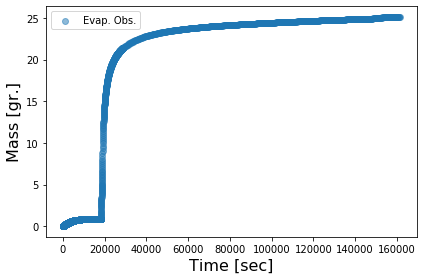

,Date,Time,Step,Mass (g),Uair (kPa)
0,7/24/2019,9:19:22 AM,Before Test,0.0,3.0
1,7/24/2019,9:19:32 AM,Before Test,0.0,3.0


In [180]:
#Reading raw evaporation data.
df = pd.read_csv('..\AGRON 935\Valley_Sub_raw.csv', sep = '\t')

#Defining the dataframe of interest to be used for calculaitng the evaporation rate.
start = 0
end = len(df)-1    #Removing the NAN's from the very end of the dataframe.
df = df[start:end]

#User input Bubble Trap measurement, in mL.
bubble_trap = float(input("Input the amount of air measured in the bubble trap in [mL]:"))    #[mL]

#Giving a meaningful names to a column of data.
df['Mass (g)'] = df['Unnamed: 3']
df['Uair (kPa)'] = df['Step']
df['Step'] = df['Time']
df['Time'] = df['Unnamed: 1']
df = df.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Notes'])

#Converting time from [[YYYY/MM/DD], [HH:MM AM/PM]] to [sec] for calculations and plotting.
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])          #from [[MM/DD/YYYY], [HH:MM, AM/PM]] to [YYYY/MM/DD, HH:MM:SS].
df['Time_diff']= df.Datetime-df.Datetime[start]                               #from [YYYY/MM/DD, HH:MM:SS] to [days, HH:MM:SS].
df['Delta_sec']= df['Time_diff'].dt.days * 86400 + df['Time_diff'].dt.seconds #from [days, HH:MM:SS] to [sec].

#Pot figure of Raw TRIM Data to check it out.
#plt.scatter(df['Delta_sec'], df['Mass (g)'], alpha = 0.5, label='Evap. Obs.')
#plt.ylabel('Mass [gr.]', fontsize = 16)
#plt.xlabel('Time [sec]', fontsize = 16)
#plt.legend()
#plt.tight_layout()
#plt.show()

#Sort data into 'Before Test', 'small increment', and 'Large increment' lists via indexes.
#Preallocate lists to store appropriate index values.
b4_test_idx = []
sm_inc_idx = []
lg_inc_idx = []

#Using a for loop to sort index values based on step: before test, samll increment, and large increment.
for index in range(len(df.Step)):
    if df.Step[index] == 'Before Test':
        b4_test_idx.append(index)
    elif df.Step[index] == 'small increment':
        sm_inc_idx.append(index)
    else:
        lg_inc_idx.append(index)
    
#Finding the max and minimum index value for the small and large increment steps. 
#np.min(small_inc_idx), np.max(small_inc_idx)
#np.min(large_inc_idx), np.max(large_inc_idx)

#User input Bubble Trap measurement, in mL.
#bubble_trap = float(input("Input the amount of air measured in the bubble trap in [mL]:"))    #[mL]

#Calculate the mass of water released during the Large increment, in grams. 
H2O_lg_inc = df['Mass (g)'][np.max(lg_inc_idx)] - df['Mass (g)'][np.min(lg_inc_idx)] #[gr.]

#Calculate the rate of diffused air during the Large increment.
rt_diff_air = bub_trap / H2O_lg_inc
print('The rate of diffused air is:', round(rt_diff_air,2), 'mL/gr.')

#Create an array of large increment mass values for element-wise corrections.
lg_inc_array = np.array(df['Mass (g)'])

#Prealocate a temporary list to store corrected mass values.
Corrected_masses = []

#Using a for loop to correct each mass during the Large increment. Correct_Mass1 = Mass1 - (Mass1 - Mass0) * Rate_diff_air.
for index in range(np.min(lg_inc_idx),np.max(lg_inc_idx)):
    new_mass = lg_inc_array[index] - (lg_inc_array[index] - lg_inc_array[index-1]) * rt_diff_air
    Corrected_masses.append([new_mass])
    
#Create a second dataframe of Corrected large increment masses.
df2 = pd.DataFrame(Corrected_masses)
df2['Mass (g)'] = df2

#For loop will replace the old large increment masses in the original dataframe with the new/corrected masses in the second dataframe.
for index in range(np.min(lg_inc_idx), np.max(lg_inc_idx)):
    index2 = index - np.min(lg_inc_idx)
    old_mass = df['Mass (g)'][index]
    new_mass = df2['Mass (g)'][index2]
    df['Mass (g)'] = df['Mass (g)'].replace(old_mass, new_mass)
    
old_mass = np.array(df['Mass (g)'])
evap_rate = 0.0927/86400
Corrected_masses = []

for index in range(len(old_mass)):
    vaped = df.Delta_sec[index] * evap_rate
    new_mass = old_mass[index] + evaped
    Corrected_masses.append(new_mass)
    
#Pot figure of Raw TRIM Data to check it out.
plt.scatter(df['Delta_sec'], df['Mass (g)'], alpha = 0.5, label='Evap. Obs.')
plt.ylabel('Mass [gr.]', fontsize = 16)
plt.xlabel('Time [sec]', fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()    

df = df.drop(columns = ['Datetime', 'Time_diff', 'Delta_sec'])
df.head(2)

In [138]:
Before_Test = df['Step'].str.match('Before Test')
Small_inc = df['Step'].str.match('small increment')
Large_inc = df['Step'].str.match('Large increment')